### Some imports

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

2024-05-19 10:37:22.408813: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-19 10:37:22.467059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 10:37:23.027631: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")

In [3]:
tsla_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## PART I

In [4]:
# Load Tesla stock data
tesla_data = tsla_df

# Ensure Date is the index
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

# Sort data by date
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

# Use 'Close' price for prediction
data = tesla_data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(scaled_data) * 0.7)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 60
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Reshape data to fit LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [5]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 2.0948e-04 - val_loss: 0.0031
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.4309e-06 - val_loss: 0.0020
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.8298e-06 - val_loss: 0.0027
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 7.0476e-06 - val_loss: 0.0022
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.7622e-06 - val_loss: 0.0017
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.8555e-06 - val_loss: 0.0020
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.5084e-06 - val_loss: 0.0014
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.2955e-06 - val_loss: 0.0014
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.8217e-06 - val_loss: 0.0013
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 4.2772e-06 - val_loss: 0.0016


In [6]:
# Predict and inverse transform the scaled data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))
print(f'RMSE: {rmse}')

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
RMSE: 49.093906950451505


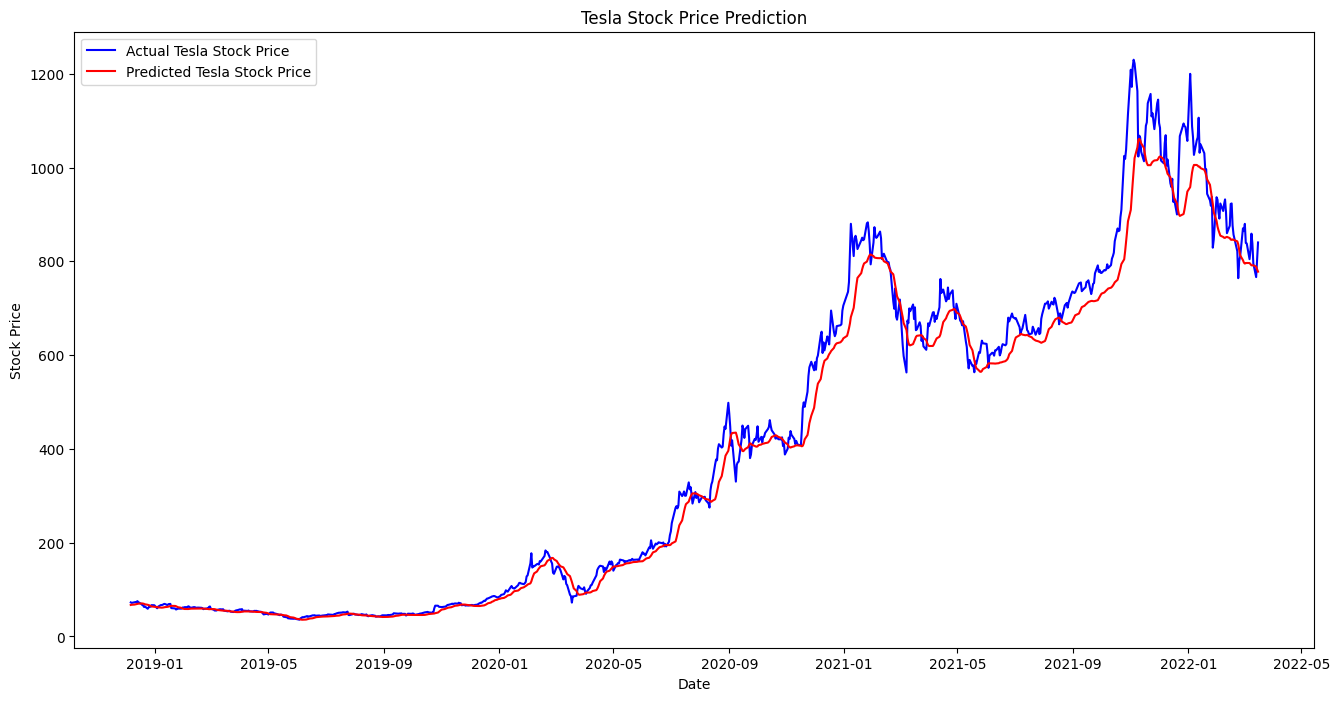

In [7]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[train_size + seq_length:], y_test_inv, color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[train_size + seq_length:], predictions, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])


# Merge Tesla and gold data on date
combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = combined[['Date', 'Close_x', 'Close_y']]

# Normalize combined data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_combined_data = scaler.fit_transform(combined_data[['Close_x', 'Close_y']])

In [9]:
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [10]:
X, Y = create_dataset_with_gold(scaled_combined_data, seq_length)

# Split the data into training and testing sets (70% training, 30% testing)
train_size = int(len(X) * 0.7)
test_size = len(X) - train_size
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [11]:
# Define the LSTM model
model_comb = Sequential()
model_comb.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 2)))
model_comb.add(LSTM(50, return_sequences=False))
model_comb.add(Dense(25))
model_comb.add(Dense(2))

# Compile the model
model_comb.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
# Train the model
history_comb = model_comb.fit(X_train, Y_train, batch_size=32, epochs=10)
# history_comb = model_comb.fit(X_train_comb, y_train_comb, epochs=10, batch_size=32, validation_data=(X_test_comb, y_test_comb))

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0113
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.8022e-04
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.4410e-04
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 5.4637e-04
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6739e-04
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 4.7101e-04
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.7438e-04
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.8041e-04
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.7710e-04
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4639e-04


In [13]:
train_predict = model_comb.predict(X_train)
test_predict = model_comb.predict(X_test)


62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [14]:
train_mae = mean_absolute_error(Y_train, train_predict)
test_mae = mean_absolute_error(Y_test, test_predict)

train_rmse = np.sqrt(mean_squared_error(Y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(Y_test, test_predict))

print(f'Train MAE (with gold): {train_mae}, Train RMSE (with gold): {train_rmse}')
print(f'Test MAE (with gold): {test_mae}, Test RMSE (with gold): {test_rmse}')

Train MAE (with gold): 0.009877161679742867, Train RMSE (with gold): 0.017134103797380174
Test MAE (with gold): 0.06353692386545076, Test RMSE (with gold): 0.09726930947784154


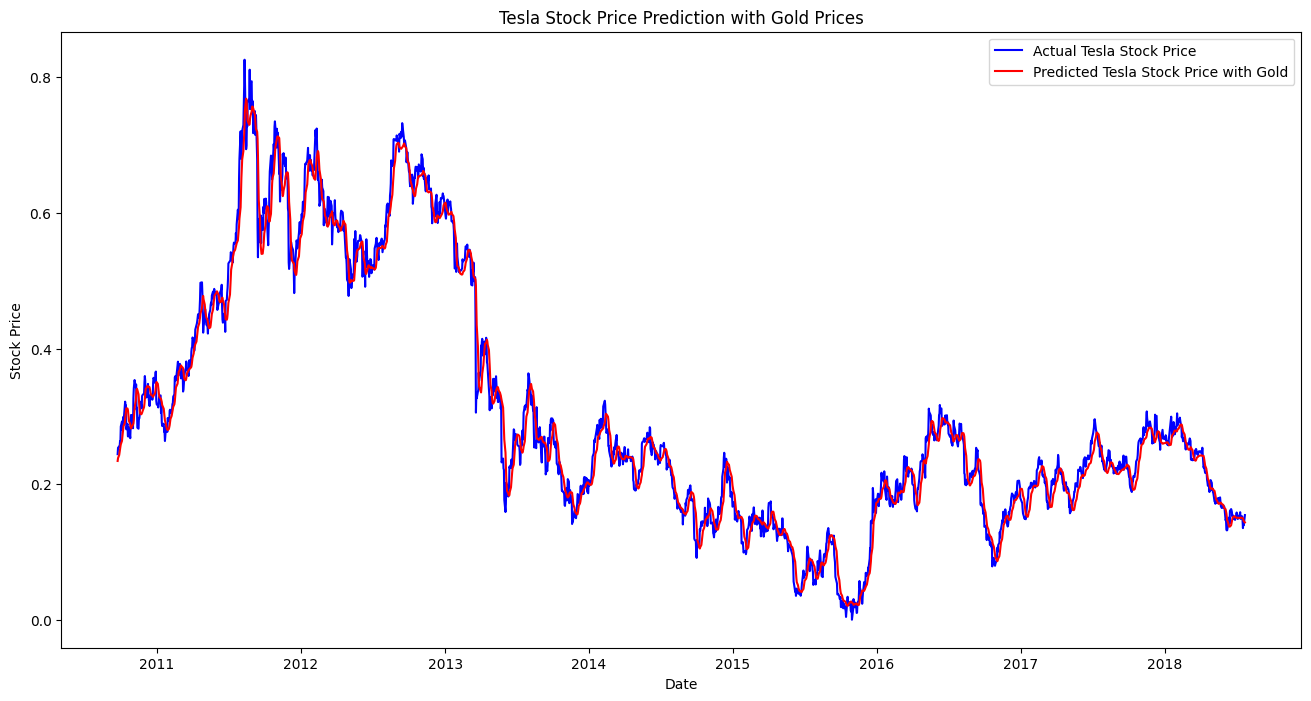

In [15]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], Y_train[:,1], color='blue', label='Actual Tesla Stock Price')
plt.plot(tesla_data.index[seq_length:train_size + seq_length:], train_predict[:,1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# PART II

### Some imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics

In [17]:
tsla_df = pd.read_csv("./docs/Homework3 - TSLA.csv")
tesla_data = tsla_df
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)
tesla_data.sort_index(inplace=True)
tesla_data = tesla_data[:2950]

# Split data into training and testing sets (70% train, 30% test)
train_size = int(len(tesla_data) * 0.7)
train_data = tesla_data[:train_size]
test_data = tesla_data[train_size:]

train_data = train_data["Close"].tolist()
test_data = test_data["Close"].tolist()

In [18]:
def to_sequences(obs, SEQUENCE_SIZE):
    x = []
    y = []

    for i in range(len(obs) - SEQUENCE_SIZE):
        #print(i)
        window = obs[i:(i + SEQUENCE_SIZE)]
        after_window = obs[i + SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x), np.array(y)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

SEQUENCE_SIZE = 10
x_train, y_train = to_sequences(train_data, SEQUENCE_SIZE)
x_test, y_test = to_sequences(test_data, SEQUENCE_SIZE)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2055, 10, 1)
Shape of test set: (875, 10, 1)


In [19]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [20]:
def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

In [21]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 1226.8217 - val_loss: 2907.6653
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 807.6484 - val_loss: 1554.7758
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 450.3209 - val_loss: 731.7083
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 279.7829 - val_loss: 287.4039
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 181.2498 - val_loss: 95.1713


In [22]:
model.summary()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 1)     │          2 │ input_layer_2[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 4)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 1)     │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 4)     │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 4)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 1)     │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 90,845 (354.87 KB)

 Trainable params: 30,281 (118.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 60,564 (236.58 KB)

In [23]:
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred, y_test))
print("Score (RMSE): {}".format(score))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Score (RMSE): 89.25300245215108


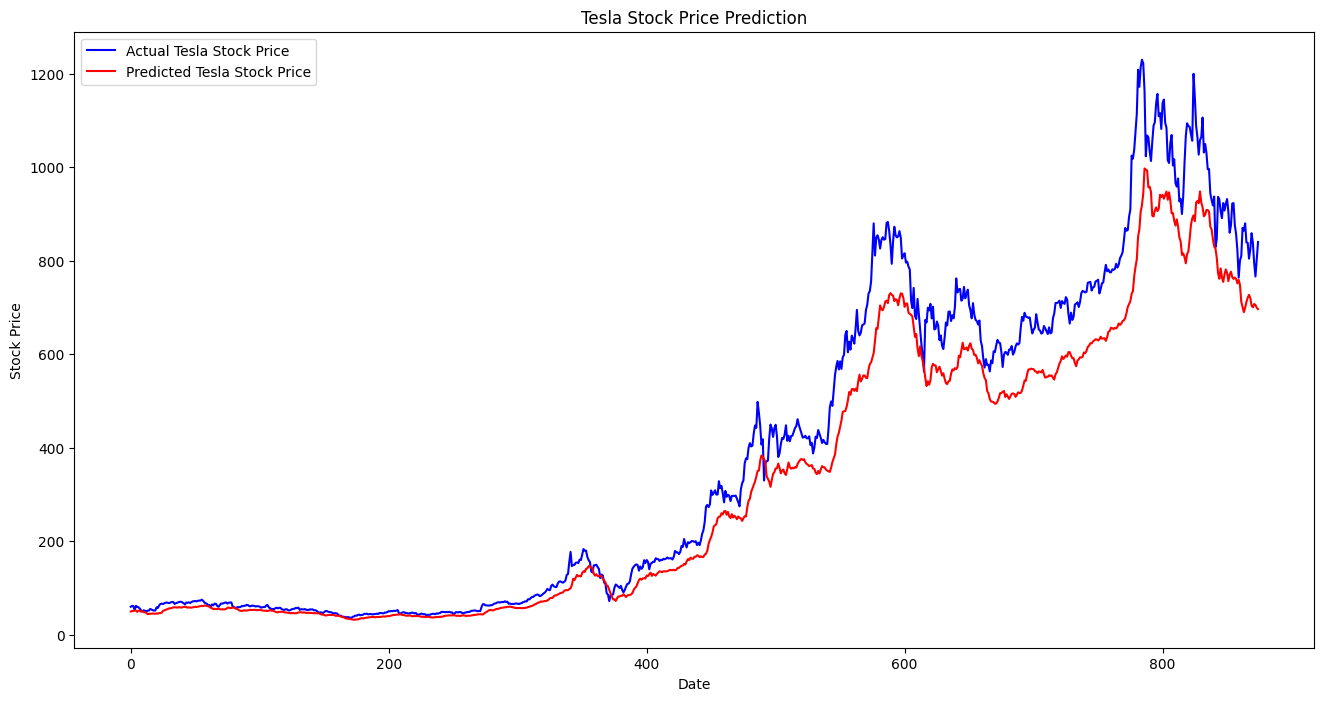

In [24]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test, color='blue', label='Actual Tesla Stock Price')
plt.plot(pred, color='red', label='Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [25]:
# Load gold price data
gold_data = pd.read_csv('./docs/gold.csv')
gold_data.sort_values('Date', inplace=True)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])

In [26]:
combined = pd.merge(tesla_data, gold_data, on='Date', how='inner')
combined_data = np.array(combined[[ 'Close_x', 'Close_y']])
# combined_data = combined[['Close_x', 'Close_y']]

In [27]:
# Prepare the dataset for LSTM
def create_dataset_with_gold(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]  # Use 'Close' and 'Gold' prices
        X.append(a)
        Y.append(dataset[i + time_step, :])  # Predict both 'Close_x' and 'Close_y'
    return np.array(X), np.array(Y)

In [28]:
X, Y = create_dataset_with_gold(combined_data, SEQUENCE_SIZE)
print("Shape of training set: {}".format(X.shape))
print("Shape of test set: {}".format(Y.shape))

Shape of training set: (2867, 10, 2)
Shape of test set: (2867, 2)


In [29]:
# Split the data into training and testing sets (70% training, 30% testing)
train_size = int(len(X) * 0.7)
x_train, x_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]


In [30]:
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (2006, 10, 2)
Shape of test set: (861, 10, 2)


In [31]:
def transformer_encoder_with_gold(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [32]:
def build_model_with_gold(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        dropout=0,
        mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder_with_gold(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    # Added the first Dense layer
    x = layers.Dense(128, activation="relu")(x)  # Added this line
    x = layers.Dropout(mlp_dropout)(x)           # Added this line
    
    outputs = layers.Dense(2)(x)
    return keras.Model(inputs, outputs)

In [33]:
input_shape = x_train.shape[1:]

model_with_gold = build_model_with_gold(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_with_gold.compile(
    loss="mean_squared_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4)
)

callbacks = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]

model_with_gold.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 725401.6875 - val_loss: 440982.9688
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 506314.2188 - val_loss: 273970.6562
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 331337.4688 - val_loss: 144642.6562
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 188794.1250 - val_loss: 63914.9805
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 113940.5156 - val_loss: 22256.6113
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 76064.2109 - val_loss: 6174.0869
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 64115.4844 - val_loss: 2002.3131
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 61353.7070 - val_loss: 1198.0967
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 60757.0117 - val_loss: 734.1769
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 58304.7305 - val_loss: 956.6896


In [34]:
model_with_gold.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 10, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ input_layer_3[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 10, 2)     │          0 │ dropout_14[0][0], │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 10, 4)     │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 10, 2)     │         10 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 10, 2)     │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 2)     │     11,266 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 10, 2)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 10, 2)     │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 2)     │          4 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 10, 4)     │         12 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 10, 4)     │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 10, 2)     │         10 │ dropout_18[0][0]

 Total params: 187,016 (730.54 KB)

 Trainable params: 62,338 (243.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 124,678 (487.03 KB)

In [35]:
pred = model_with_gold.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print("Score (RMSE): {}".format(score))

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Score (RMSE): 299.8797282244726


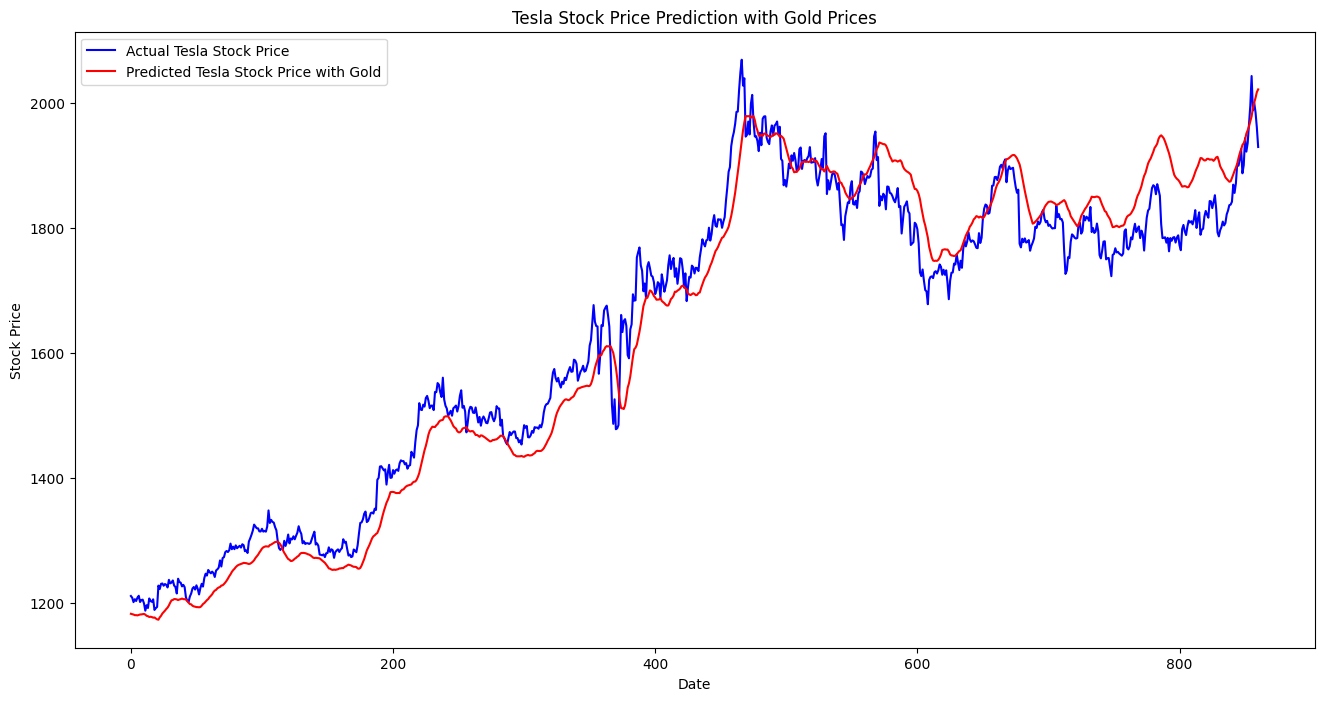

In [36]:
# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(y_test[:,1], color='blue', label='Actual Tesla Stock Price')
plt.plot(pred[:,1], color='red', label='Predicted Tesla Stock Price with Gold')
plt.title('Tesla Stock Price Prediction with Gold Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()